In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import pickle
import copy
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, brier_score_loss 
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [29]:
alpha = 0.5
gamma = 1
seq_len = 1
learning_rate = 1e-4
batch_size = 128
max_epoch = 50
experiment_time = 10
limit_early_stop_count = 5
device = torch.device("cuda")

#DNR數據是否需要upsample
use_upsample = True

#['dod','dod_3day','dod_7day','dod_30day','dod_60day','dod_90day','DNR','Weaning_successful','SBT','dialysis']
#task_name_list = ['DNR']
#task_name_list = ['dod_7day']
#task_name_list = ['dod_30day']
#task_name_list = ['dialysis']
#task_name_list = ['Weaning_successful']
#task_name_list = ['SBT']
#task_name_list = ['dod_3day']
#task_name_list = ['dod_90day']
#task_name_list = ['InvasiveVent']
#task_name_list = ['Vasopressor']
#task_name_list = ['dod_60day']

#task_name_list = ['DNR','dod_30day']
#task_name_list = ['DNR','dod_7day']
#task_name_list = ['DNR','dialysis']
#task_name_list = ['DNR','Vasopressor']
#task_name_list = ['DNR','InvasiveVent']
#task_name_list = ['DNR','SBT']
#task_name_list = ['DNR','Weaning_successful']
#task_name_list = ['DNR','dod_3day']
#task_name_list = ['DNR','dod_90day']
#task_name_list = ['DNR','dod_60day']

task_name_list = ['DNR','dod_30day','Vasopressor']
#task_name_list = ['DNR','dod_30day','InvasiveVent']
#task_name_list = ['DNR','dod_30day','dialysis']
#task_name_list = ['DNR','InvasiveVent','dialysis']
#task_name_list = ['DNR','InvasiveVent','Vasopressor']
#task_name_list = ['DNR','Vasopressor','dialysis']

#task_name_list = ['DNR','dod_30day','Vasopressor','InvasiveVent']
#task_name_list = ['DNR','dod_30day','Vasopressor','dialysis']
#task_name_list = ['DNR','dod_30day','Vasopressor','InvasiveVent','dialysis']



In [30]:
##++
class RNN_MTL(nn.Module):
    def __init__(self, input_dim, task_name_list,window_size = 3, dropout_ratio=0.0):
        super(RNN_MTL, self).__init__()
        self.dropout = nn.Dropout(dropout_ratio)
        self.relu = nn.ReLU()  
        self.sigmoid = nn.Sigmoid()
        self.task_name_list = task_name_list
        self.num_tasks = len(task_name_list)
        hidden_dim = [256, 64]
        output_size = 1
        # Bottom
        self.bi_lstm = torch.nn.LSTM(input_dim, hidden_dim[0], num_layers=2, batch_first = True, bidirectional = True)
        # Towers
        self.task_fc0 = nn.ModuleList([nn.Linear(hidden_dim[0]*window_size*2, hidden_dim[1]) for _ in range(self.num_tasks)])
        self.task_fc1 = nn.ModuleList([nn.Linear(hidden_dim[1], output_size) for _ in range(self.num_tasks)])
    
    #數據檢查
    def data_check(self,x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        #if x.ndim == 3:
        #    x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])  # Flatten 
        x = x.to(device)
        return x
    
    def forward(self, x, use_dropout = False):
        x = self.data_check(x)
        h, _   = self.bi_lstm(x)
        h = torch.nn.functional.relu(h)
        if use_dropout:
            h = nn.Dropout(p=0.5)(h)
        h = torch.flatten(h, start_dim = 1)
        
        # Towers
        task_out = {}
        for task_index in range(self.num_tasks):
            task_name = self.task_name_list[task_index]
            hi = self.task_fc0[task_index](h)
            hi = self.relu(hi)
            hi = self.dropout(hi)
            hi = self.task_fc1[task_index](hi)
            hi = self.sigmoid(hi)
            task_out[task_name] = hi    
        
        #STL => 不回傳dict
        if len(self.task_name_list) == 1:
            return task_out[self.task_name_list[0]]
        #MTL => 回傳dict
        else:
            return task_out
    
    #eval. 固定回傳dict
    def predict_prob(self, x , use_dropout = False):
        prob_dict = self.forward(x,use_dropout)
        if len(self.task_name_list) == 1:
            prob_dict_true = {}
            prob_dict_true[self.task_name_list[0]] = prob_dict
            return prob_dict_true
        return prob_dict
    
    #將預測結果轉標籤
    def predict(self, x, threshold = 0.5):
        self.eval()
        prob_dict = self.predict_prob(x)
        pred_dict = {}
        for key, value in prob_dict.items():
            #tensor轉numpy
            value = value.cpu().detach().numpy()
            pred_class = [1 if x > threshold else 0 for x in value]
            pred_dict[key] = np.array(pred_class) 
        return pred_dict
    
    #計算評估指標
    def evaluate(self,X,label,task_name,criterion):
        with torch.no_grad():
            prob = self.predict_prob(X)[task_name].cpu().detach().numpy() #tensor=>numpy
            pred = self.predict(X)[task_name] 
            score = compute_scores(label,pred,prob)
            score['task'] = task_name
            loss = criterion(torch.from_numpy(prob).to(device),torch.from_numpy(label).to(device)).item()
            score['loss'] = loss/len(label)

            #新增 'predictions' 到 score，讓 test2() 可以存取
            score['predictions'] = pred

            return score


In [31]:
"""
計算評估指標
y_true: label
y_pred: 預測標籤
y_prob: 預測機率
"""
def compute_scores(y_true, y_pred, y_prob):
    scores = {}
    try:
        scores['task'] = 'Null'
        scores['auroc'] = round(roc_auc_score(y_true, y_prob), 3)
        scores['acc'] = round(accuracy_score(y_true, y_pred), 3)
        scores['f1'] = round(f1_score(y_true, y_pred), 3)
        scores['pre'] = round(precision_score(y_true, y_pred), 3)
        scores['recall'] = round(recall_score(y_true, y_pred), 3)
        scores['brier_score'] = round(brier_score_loss(y_true, y_prob), 3)
    except Exception as e:
        print("An error occurred:", str(e))
    return scores


In [32]:
def train(model, loader_dict, criterion, optimizer):
    

    train_loss = 0
    task_name_list = list(loader_dict.keys())

    """
    cycle_loader
    """
    max_length = 0
    cycle_loader_dict = {}
    for task_name, dataloader in loader_dict.items():
        current_length = len(dataloader)
        max_length = max(max_length, current_length)
        cycle_loader_dict[task_name] = itertools.cycle(dataloader)
    model.train()
    for i in range(max_length):
        optimizer.zero_grad()
        total_loss = torch.zeros(1).to(device)
        
        for task_name in task_name_list:  
            data = next(cycle_loader_dict[task_name])
            x = data[0].to(device)
            label = data[1].unsqueeze(1).to(device)
            
            prob = model.predict_prob(x,True)[task_name]
            loss = criterion(prob, label)
            total_loss += loss
        
        
        total_loss.backward()
        train_loss+=total_loss.item()
        optimizer.step()
        
        #資料用完的任務集重新循環
        for task_name in task_name_list: 
            if (i + 1) % len(loader_dict[task_name]) == 0:
                cycle_loader_dict[task_name] = itertools.cycle(loader_dict[task_name])
    
    #棄用
    train_loss /= max_length* 256 * len(task_name_list)
    
    return train_loss

In [33]:
"""
Input:
    model
    dict: Mydataset
    loss_function
Output:
    score: dict + dict
    result: dict => ['total_auc','total_loss']
"""
def test(model, dataset_dict, criterion, is_show = True ):
    model.eval()

    task_name_list = list(dataset_dict.keys())
    score = {}
    result = {'total_auc': 0, 'total_loss': 0}
    for task_name in task_name_list:  # 循環每個任務
        X = dataset_dict[task_name].inputs.numpy()
        Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
    
        score[task_name] = model.evaluate(X,Y,task_name,criterion)
        
        result['total_auc'] = result['total_auc'] + score[task_name]['auroc']
        result['total_loss'] = result['total_loss'] + score[task_name]['loss']
            
        if is_show:
            print(score[task_name])

    return score,result

"""
local_best_model_dict: #dict{'task_name':{'model','performance(target_score)','id'}}
model
"""
def test2(local_best_model_dict, dataset_dict, criterion, is_show = True):
    score = {}
    result = {'total_auc': 0, 'total_loss': 0}
    task_name_list = list(dataset_dict.keys())
    
    for task_name in task_name_list:
        modelr = local_best_model_dict[task_name]['model']
        modelr.eval()
        X = dataset_dict[task_name].inputs.numpy()
        Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
        score[task_name] = modelr.evaluate(X,Y,task_name,criterion)
        result['total_auc'] = result['total_auc'] + score[task_name]['auroc']
        result['total_loss'] = result['total_loss'] + score[task_name]['loss']


        if is_show:
            print(score[task_name])

    
    return score,result


In [34]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class MyDataset(Dataset):
    def __init__(self, np_X_scalar,np_X_original, np_Y):
        self.inputs = torch.from_numpy(np_X_scalar).float()
        self.inputs_original = torch.from_numpy(np_X_original).float()
        self.labels = torch.from_numpy(np_Y).float()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]
    

class BCEFocalLoss(torch.nn.Module):

    def __init__(self, gamma=2, alpha=0.25, reduction='elementwise_mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
 
    def forward(self, _input, target):
        pt = _input
        alpha = self.alpha
        loss = - alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
               (1 - alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt)
        if self.reduction == 'elementwise_mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss    

    
def check_label_distribution (data_Y):
    count_1 = np.count_nonzero(data_Y == 1)
    count_0 = np.count_nonzero(data_Y == 0)
    count_others = np.count_nonzero((data_Y != 1) & (data_Y != 0))
    ratio_1 = round(count_1/len(data_Y)*100,2)
    ratio_0 = round(count_0/len(data_Y)*100,2)
    ratio_others = round(count_others/len(data_Y)*100,2)
    print(f'Distribution: 1=>{count_1}({ratio_1}%),  0=>{count_0}({ratio_0}%),  others=>{count_others}({ratio_others}%)')

    
def upsampling_auto(X,X_original,Y,up_ratio):
    check_label_distribution(Y)
    zero_idx = np.where(Y == 0)[0]
    one_idx = np.where(Y == 1)[0]
    other_idx = np.where((Y != 1) & (Y != 0))[0]
    if len(other_idx > 0):
        return X,Y
    repeated_data_X = np.tile(X[one_idx], (up_ratio, 1, 1))
    repeated_data_X_original = np.tile(X_original[one_idx], (up_ratio, 1, 1))
    repeated_data_Y = np.tile(Y[one_idx], (up_ratio))

    X_upsampled = np.vstack((X[zero_idx], repeated_data_X))
    X_original_upsampled = np.vstack((X_original[zero_idx], repeated_data_X_original))

    Y_upsampled = np.concatenate((Y[zero_idx], repeated_data_Y)) 
    return X_upsampled, X_original_upsampled, Y_upsampled

In [35]:
import numpy as np

"""
Input:
    X: numpy
    feature_name_list : List
    select_feature_list : List   (必須是feature_name_list的子集)
Output
    select_feature_list data
"""
def select_features(X, feature_name_list, select_feature_list):
    invalid_features = set(select_feature_list) - set(feature_name_list)
    if invalid_features:
        raise ValueError(f"Invalid features in select_feature_list: {invalid_features}")
    selected_feature_indices = [feature_name_list.index(feature) for feature in select_feature_list]
    X_selected = X[:, :, selected_feature_indices]

    return X_selected


In [36]:
import numpy as np

"""
Input:
    dataset_dict: Mydataset 
    loader_dict: Dataloader
    feature_name_list: List
    select_feature_list: List  => 若為空，則擷取所有特徵
    batch_size: 256

Output:
    dataset_dict
    loader_dict
    feature_name_list ==>
"""

def read_data(task_name_list, data_date ,data_type, select_feature_list = [], batch_size = 256,use_upsample = False):
    #檔案位置
    #data_path = "./data/sample/standard_data"
    
    #data_path = "C:/Users/USER/M1326168/MIMIC/DNR/20250219/data/sample/standard_data"
    data_path = "C:/Users/USER/M1326168/MIMIC/DNR/20250507/data/sample/standard_data"

    #Feature name
    #df_feature = pd.read_csv("./data/sample/full_feature_name.csv")
    #df_feature = pd.read_csv("C:/Users/USER/M1326168/MIMIC/DNR/20250219/data/sample/full_feature_name.csv")
    df_feature = pd.read_csv("C:/Users/USER/M1326168/MIMIC/DNR/20250507/data/sample/full_feature_name.csv")   
    feature_name_list = df_feature.columns.to_list()
    
    #Dataset
    dataset_dict = {}
    for task_name in task_name_list:
        X_scalar = np.load(f"{data_path}/{data_type}_scalar_X_{task_name}.npy", allow_pickle=True)
        X_original = np.load(f"{data_path}/{data_type}_X_{task_name}.npy", allow_pickle=True)
        
        if len(select_feature_list)>0:
            X_scalar = select_features(X_scalar,feature_name_list,select_feature_list)
            X_original = select_features(X_original,feature_name_list,select_feature_list)
            assert X_scalar.shape[2] == len(select_feature_list)
            assert X_original.shape[2] == len(select_feature_list)

        Y = np.load(f"{data_path}/{data_type}_Y_{task_name}.npy", allow_pickle=True)
        
        if use_upsample:
            if task_name == 'DNR' and data_type != 'test':
                X_scalar,X_original,Y = upsampling_auto(X_scalar,X_original,Y,2)
                
        dataset_dict[task_name] = MyDataset(X_scalar,X_original,Y)
    
    #Dataloader
    loader_dict = {}
    for key, dataset in dataset_dict.items():        
        loader_dict[key] = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return dataset_dict,loader_dict,feature_name_list


In [37]:
#輸入多任務模型 => 拆解回多個單任務模型
def MTL_to_STL(multi_task_model,input_dim):
    single_task_models = {}
    
    for task_index, task_name in enumerate(multi_task_model.task_name_list):
        
        single_task_model = RNN_MTL(input_dim,[task_name]).to(device)
        
        #Bottom
        # 複製bi_lstm的權重和偏差到model2的對應層中
        single_task_model.bi_lstm.weight_ih_l0.data = multi_task_model.bi_lstm.weight_ih_l0.data.clone()
        single_task_model.bi_lstm.weight_hh_l0.data = multi_task_model.bi_lstm.weight_hh_l0.data.clone()
        single_task_model.bi_lstm.bias_ih_l0.data = multi_task_model.bi_lstm.bias_ih_l0.data.clone()
        single_task_model.bi_lstm.bias_hh_l0.data = multi_task_model.bi_lstm.bias_hh_l0.data.clone()
        
        single_task_model.bi_lstm.weight_ih_l1.data = multi_task_model.bi_lstm.weight_ih_l1.data.clone()
        single_task_model.bi_lstm.weight_hh_l1.data = multi_task_model.bi_lstm.weight_hh_l1.data.clone()
        single_task_model.bi_lstm.bias_ih_l1.data = multi_task_model.bi_lstm.bias_ih_l1.data.clone()
        single_task_model.bi_lstm.bias_hh_l1.data = multi_task_model.bi_lstm.bias_hh_l1.data.clone()
        
        single_task_model.bi_lstm.weight_ih_l0_reverse.data = multi_task_model.bi_lstm.weight_ih_l0_reverse.data.clone()
        single_task_model.bi_lstm.weight_hh_l0_reverse.data = multi_task_model.bi_lstm.weight_hh_l0_reverse.data.clone()
        single_task_model.bi_lstm.bias_ih_l0_reverse.data = multi_task_model.bi_lstm.bias_ih_l0_reverse.data.clone()
        single_task_model.bi_lstm.bias_hh_l0_reverse.data = multi_task_model.bi_lstm.bias_hh_l0_reverse.data.clone()
        
        single_task_model.bi_lstm.weight_ih_l1_reverse.data = multi_task_model.bi_lstm.weight_ih_l1_reverse.data.clone()
        single_task_model.bi_lstm.weight_hh_l1_reverse.data = multi_task_model.bi_lstm.weight_hh_l1_reverse.data.clone()
        single_task_model.bi_lstm.bias_ih_l1_reverse.data = multi_task_model.bi_lstm.bias_ih_l1_reverse.data.clone()
        single_task_model.bi_lstm.bias_hh_l1_reverse.data = multi_task_model.bi_lstm.bias_hh_l1_reverse.data.clone()
        
        #Tower
        single_task_model.task_fc0[0].weight.data = multi_task_model.task_fc0[task_index].weight.data.clone()
        single_task_model.task_fc0[0].bias.data = multi_task_model.task_fc0[task_index].bias.data.clone()

        single_task_model.task_fc1[0].weight.data = multi_task_model.task_fc1[task_index].weight.data.clone()
        single_task_model.task_fc1[0].bias.data = multi_task_model.task_fc1[task_index].bias.data.clone()

        single_task_models[task_name] = single_task_model
        
    return single_task_models

In [38]:
"""            
儲存模型參數
"""
def save_model(task_name_list, model_parm_dict, time=1):
    #path = './model_parm'
    
    #path = 'C:/Users/USER/M1326168/MIMIC/DNR/20250219/model_parm'
    path = 'C:/Users/USER/M1326168/MIMIC/DNR/20250507/model_parm'
    for task_name in task_name_list:
        model_parm = model_parm_dict[task_name].state_dict().copy()
        torch.save(model_parm, f'{path}/{task_name}_{time}')

    

In [39]:
"""
Input:
    experiment_time, 
    max_epoch, 
    learning_rate, 
    input_dim, 
    task_name_list, 
    train_loader_dict, 
    val_dataset_dict, 
    test_dataset_dict, 
    device,
    is_show = True 

Output:
    df_grade
    stl_model_dict
"""


def train_and_test_model(experiment_time, max_epoch, learning_rate, input_dim, task_name_list, train_loader_dict, val_dataset_dict, test_dataset_dict, device,is_show = True):
    df_grade = pd.DataFrame(columns=['time', 'task', 'auroc', 'acc', 'f1', 'pre', 'recall', 'brier_score', 'loss'])
    best_model_params = {}
    global_best_AUC = 0
    global_best_loss = 10000
    best_model_dict = {} 
    
    count = 1
    local_indicator = 'auroc'
    global_indicator = 'loss'
    

    for time in range(experiment_time):
        train_loss_list = []
        val_loss_list = []
        auc_list = []    
        local_best_AUC = 0
        local_best_loss = 10000
        local_best_model_dict = {} 
        patience_counter = 0
        
        model = RNN_MTL(input_dim, task_name_list).to(device)
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
        loss_func = BCEFocalLoss(alpha=alpha, gamma=gamma)
        # ++
        for epoch in tqdm(range(max_epoch)):
            if is_show:
                print(f'Time:{time+1}/{experiment_time} - Epoch:{epoch+1}/{max_epoch}...')

            train_loss = train(model, train_loader_dict, loss_func, optimizer)
            val_score_dict, result = test(model, val_dataset_dict, loss_func, is_show= is_show)

            train_loss_list.append(train_loss)
            val_loss_list.append(result['total_loss'])
            auc_list.append(result['total_auc'])
            
            ########################################################################################################################
            #每個任務都保留當前epoch最佳的多任務模型(local best)
            for task_name in task_name_list:
                if task_name not in local_best_model_dict:
                    model_dict = {}
                    model_dict['model'] = copy.deepcopy(model)
                    model_dict['performance'] = val_score_dict[task_name]
                    model_dict['id'] = count
                    local_best_model_dict[task_name] = model_dict
                else:
                    target_score = val_score_dict[task_name]
                    if local_indicator == 'auroc':
                        if local_best_model_dict[task_name]['performance'][local_indicator] < target_score[local_indicator] :
                            local_best_model_dict[task_name]['performance'] = target_score
                            local_best_model_dict[task_name]['model'] = copy.deepcopy(model)
                            local_best_model_dict[task_name]['id'] = count                           
                    else:
                        if local_best_model_dict[task_name]['performance'][local_indicator] > target_score[local_indicator] :
                            local_best_model_dict[task_name]['performance'] = target_score
                            local_best_model_dict[task_name]['model'] = copy.deepcopy(model)
                            local_best_model_dict[task_name]['id'] = count
            
            #所有實驗裡最佳紀錄(best)
            for task_name in task_name_list:
                if task_name not in best_model_dict:
                    model_dict = {}
                    model_dict['model'] = copy.deepcopy(model)
                    model_dict['performance'] = val_score_dict[task_name]
                    model_dict['id'] = count
                    best_model_dict[task_name] = model_dict
                else:
                    target_score = val_score_dict[task_name]
                    if local_indicator == 'auroc':
                        if best_model_dict[task_name]['performance'][local_indicator] < target_score[local_indicator] :
                            best_model_dict[task_name]['performance'] = target_score
                            best_model_dict[task_name]['model'] = copy.deepcopy(model)
                            best_model_dict[task_name]['id'] = count
                    else:
                        if best_model_dict[task_name]['performance'][local_indicator] > target_score[local_indicator] :
                            best_model_dict[task_name]['performance'] = target_score
                            best_model_dict[task_name]['model'] = copy.deepcopy(model)
                            best_model_dict[task_name]['id'] = count
            count+=1
            ########################################################################################################################
            """ Early stop """
            if global_indicator == 'loss':
                if result['total_loss'] < local_best_loss:
                    local_best_loss = result['total_loss']
                    if local_best_loss < global_best_loss:
                        global_best_loss = local_best_loss
                        best_model_params = model.state_dict().copy() 
                    patience_counter = 0
                else:
                    patience_counter += 1     
            else:
                if result['total_auc'] > local_best_AUC:
                    local_best_AUC = result['total_auc']
                    if local_best_AUC > global_best_AUC:
                        global_best_AUC = local_best_AUC
                        best_model_params = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1 
            
            global limit_early_stop_count
            if patience_counter >= limit_early_stop_count:
                break
            ########################################################################################################################
            
        test_score_dict, result = test2(local_best_model_dict, test_dataset_dict, loss_func, is_show = True)
        ############################################################################################################################
        #每次實驗，每個任務都保留最佳model
        save_model_dict = {}
        for task_name in task_name_list:
            local_stl_model_dict = MTL_to_STL(local_best_model_dict[task_name]['model'],input_dim)
            save_model_dict[task_name] = local_stl_model_dict[task_name]        
        save_model(task_name_list, save_model_dict, time+1)
        ############################################################################################################################
        print("最終分數")
        for task_name in task_name_list:
            test_score_dict[task_name]['time'] = time + 1
            df_grade = pd.concat([df_grade, pd.DataFrame.from_records([test_score_dict[task_name]])])
        print(df_grade)
        print('----------finished----------')
    
    global_stl_model_dict = {}
    for task_name in task_name_list:
        local_stl_model_dict = MTL_to_STL(best_model_dict[task_name]['model'],input_dim)    
        global_stl_model_dict[task_name] = local_stl_model_dict[task_name]


    #predictions = test2(local_best_model_dict, test_dataset_dict, loss_func, is_show = True)

    # 取出某個 task 的預測標籤
    # task_name = "DNR"
    # print("真實標籤 (Y_true):", predictions[task_name]['Y_true'].flatten()[:10])
    # print("預測機率 (Y_pred_prob):", predictions[task_name]['Y_pred_prob'].flatten()[:10])
    # print("預測標籤 (Y_pred_label):", predictions[task_name]['Y_pred_label'].flatten()[:10])
    
    return df_grade, global_stl_model_dict, best_model_dict
    
    

In [40]:
from datetime import datetime

start_time = datetime.now()

# Start

In [41]:
select_feature_list = []
top_percent = 0.9
remove_time_count = 0
full_result_dict = {}
featurn_count_list = []

########################################################################################################################
remove_time_count += 1
"""
read data
"""
train_dataset_dict,train_loader_dict,feature_name_list = read_data(task_name_list,'','train',select_feature_list,batch_size = batch_size,use_upsample = use_upsample)
val_dataset_dict,val_loader_dict,_ = read_data(task_name_list,'','validation',select_feature_list,batch_size = batch_size,use_upsample = use_upsample)
test_dataset_dict,test_loader_dict,_ = read_data(task_name_list,'','test',select_feature_list,batch_size = batch_size,use_upsample = use_upsample)
if len(select_feature_list)!=0:
    feature_name_list = select_feature_list
input_dim = train_dataset_dict[task_name_list[0]].inputs.numpy().shape[2]
print(f'==> input_dim: {input_dim}')
featurn_count_list.append(input_dim)
########################################################################################################################

"""
Train
"""
print("training")
df_grade, stl_model_dict, best_model_dict = train_and_test_model(experiment_time = experiment_time, 
                                                 max_epoch = max_epoch, 
                                                 learning_rate = learning_rate, 
                                                 input_dim = input_dim, 
                                                 task_name_list = task_name_list, 
                                                 train_loader_dict = train_loader_dict, 
                                                 val_dataset_dict = val_dataset_dict, 
                                                 test_dataset_dict = test_dataset_dict, 
                                                 device = device, is_show = False)
df_grade['remove_time'] = remove_time_count
full_result_dict[remove_time_count] = {}
full_result_dict[remove_time_count]['result'] = df_grade
full_result_dict[remove_time_count]['model'] = stl_model_dict
full_result_dict[remove_time_count]['select_feature_list'] = feature_name_list




Distribution: 1=>2440(31.86%),  0=>5218(68.14%),  others=>0(0.0%)
Distribution: 1=>346(36.15%),  0=>611(63.85%),  others=>0(0.0%)
==> input_dim: 271
training


 20%|██        | 10/50 [00:20<01:20,  2.00s/it]
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _V

{'task': 'DNR', 'auroc': 0.799, 'acc': 0.721, 'f1': 0.564, 'pre': 0.478, 'recall': 0.689, 'brier_score': 0.177, 'loss': 0.0001370590296816975, 'predictions': array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,

 18%|█▊        | 9/50 [00:17<01:18,  1.92s/it]
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF

{'task': 'DNR', 'auroc': 0.807, 'acc': 0.765, 'f1': 0.57, 'pre': 0.548, 'recall': 0.594, 'brier_score': 0.16, 'loss': 0.000125154168471414, 'predictions': array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

 16%|█▌        | 8/50 [00:15<01:21,  1.95s/it]
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF

{'task': 'DNR', 'auroc': 0.801, 'acc': 0.719, 'f1': 0.568, 'pre': 0.476, 'recall': 0.705, 'brier_score': 0.181, 'loss': 0.00014075615087481283, 'predictions': array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0

 16%|█▌        | 8/50 [00:15<01:21,  1.94s/it]
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF

{'task': 'DNR', 'auroc': 0.797, 'acc': 0.721, 'f1': 0.567, 'pre': 0.478, 'recall': 0.697, 'brier_score': 0.178, 'loss': 0.00013835732834821952, 'predictions': array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0

 16%|█▌        | 8/50 [00:15<01:22,  1.96s/it]
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF

{'task': 'DNR', 'auroc': 0.799, 'acc': 0.74, 'f1': 0.564, 'pre': 0.503, 'recall': 0.641, 'brier_score': 0.169, 'loss': 0.00013107448691863853, 'predictions': array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,

 20%|██        | 10/50 [00:19<01:16,  1.91s/it]
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _V

{'task': 'DNR', 'auroc': 0.802, 'acc': 0.716, 'f1': 0.56, 'pre': 0.471, 'recall': 0.689, 'brier_score': 0.177, 'loss': 0.00013871649610722487, 'predictions': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,

 16%|█▌        | 8/50 [00:15<01:21,  1.95s/it]
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF

{'task': 'DNR', 'auroc': 0.801, 'acc': 0.724, 'f1': 0.564, 'pre': 0.482, 'recall': 0.681, 'brier_score': 0.175, 'loss': 0.00013676872146403367, 'predictions': array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0

 18%|█▊        | 9/50 [00:17<01:19,  1.94s/it]
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF

{'task': 'DNR', 'auroc': 0.792, 'acc': 0.741, 'f1': 0.534, 'pre': 0.505, 'recall': 0.566, 'brier_score': 0.165, 'loss': 0.00013028673189915794, 'predictions': array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0

 20%|██        | 10/50 [00:19<01:16,  1.91s/it]
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _V

{'task': 'DNR', 'auroc': 0.798, 'acc': 0.738, 'f1': 0.562, 'pre': 0.5, 'recall': 0.641, 'brier_score': 0.17, 'loss': 0.00013338845993133576, 'predictions': array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

 18%|█▊        | 9/50 [00:18<01:22,  2.02s/it]
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF

{'task': 'DNR', 'auroc': 0.789, 'acc': 0.698, 'f1': 0.553, 'pre': 0.452, 'recall': 0.713, 'brier_score': 0.187, 'loss': 0.0001455010974581406, 'predictions': array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,

Running Calibration on Test Data...


c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


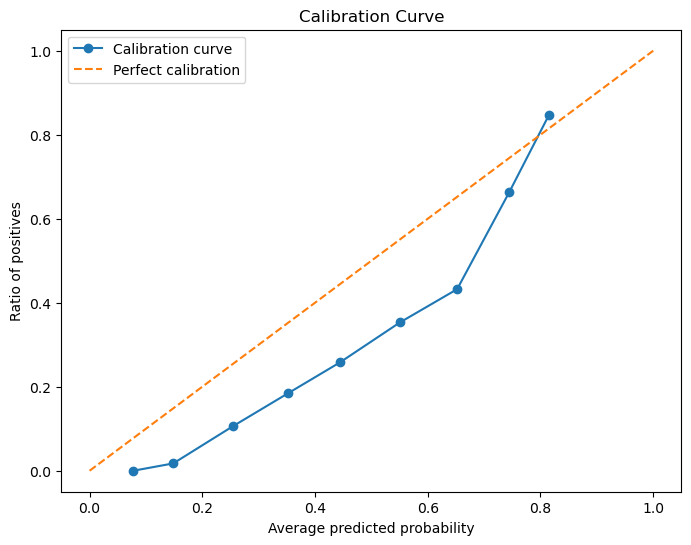

c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


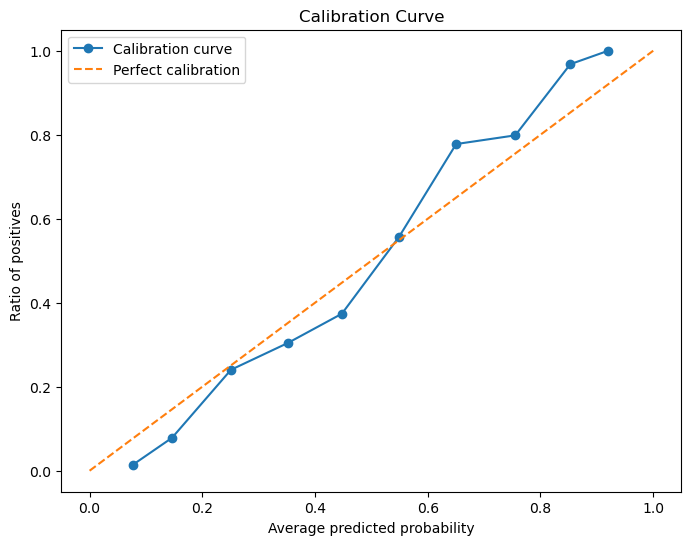

c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


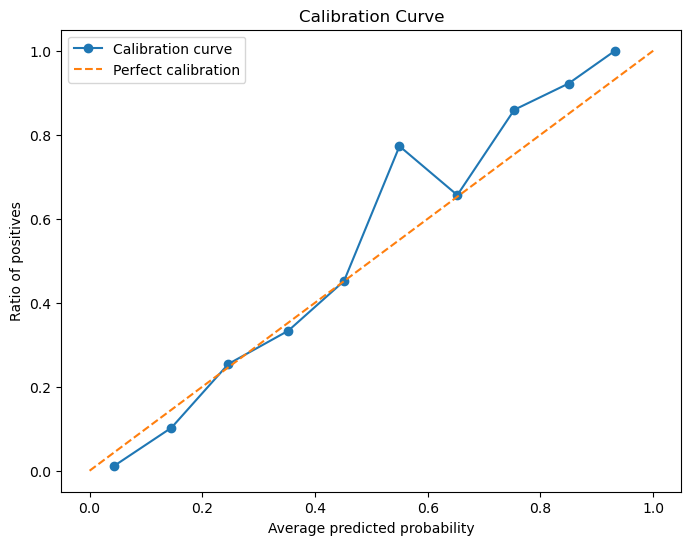

In [42]:
#calibration_curve
#彩色版 ，棄用
#需手動操作

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

#跑第二次要註解掉
# def save_predictions(predictions, filename):
#      np.save(filename, predictions)


def calibration(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
    plt.xlabel('Average predicted probability')
    plt.ylabel('Ratio of positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()   

def run_calibration(local_best_model_dict, dataset_dict):
    task_name_list = list(dataset_dict.keys())
    calibration_results = {}

    for task_name in task_name_list:
        model = local_best_model_dict[task_name]['model']
        model.eval()
        X = dataset_dict[task_name].inputs.numpy()
        Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
        
        prob = model.predict_prob(X)[task_name].cpu().detach().numpy()
        preds = Y.flatten()
        
        calibration(preds, prob)  # 傳遞兩個參數

        
        # 儲存預測結果，跑第二次記得註解掉
        #save_predictions(prob, f"C:/Users/USER/M1326168/MIMIC/DNR/20250507/model_parm/{task_name}_predictions.npy")

    return calibration_results

print("Running Calibration on Test Data...")
calibration_results = run_calibration(best_model_dict, test_dataset_dict)

Running Calibration Curve on Test Data...


c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


圖表已儲存為 TIFF 檔案：C:/Users/USER/M1326168/MIMIC/DNR/20250528/calibration_curve.tiff


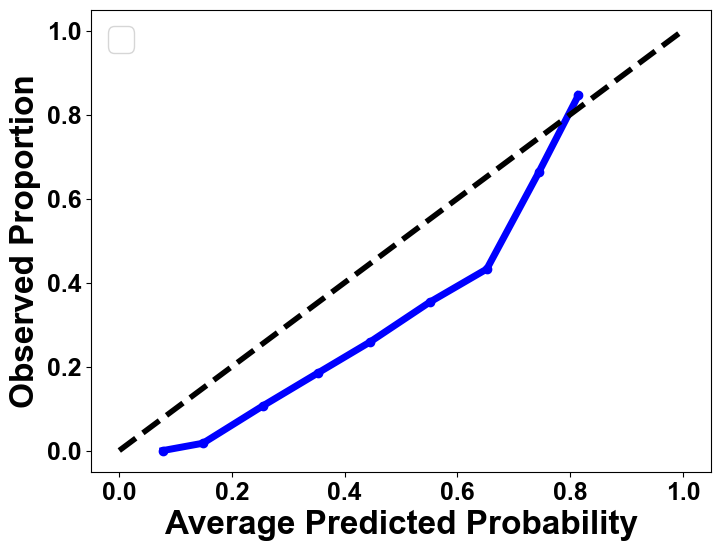

c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


圖表已儲存為 TIFF 檔案：C:/Users/USER/M1326168/MIMIC/DNR/20250528/calibration_curve.tiff


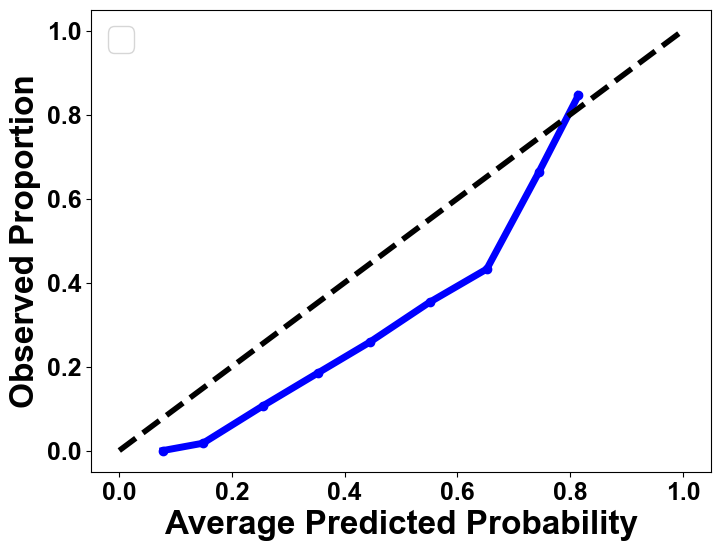

c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


圖表已儲存為 TIFF 檔案：C:/Users/USER/M1326168/MIMIC/DNR/20250528/calibration_curve.tiff


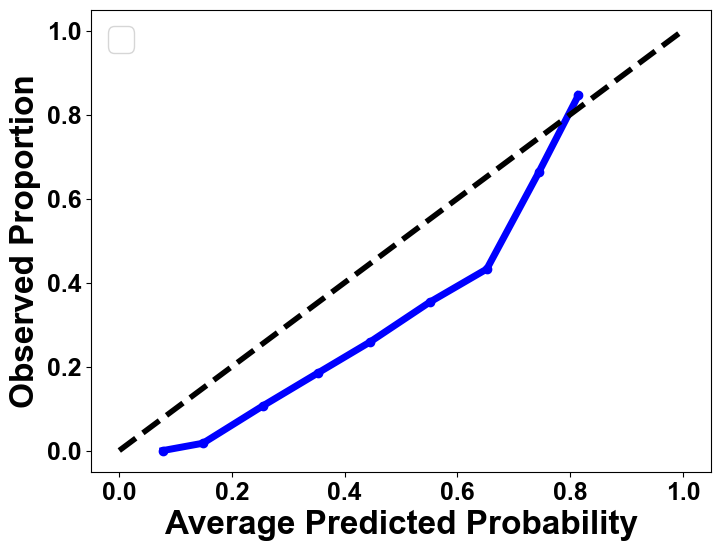

In [77]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np

def plot_calibration_curve(y_true, y_prob, model_name, n_bins=10, save_path=None):
    """
    繪製校準曲線 (Calibration Curve)
    :param y_true: 真實標籤
    :param y_prob: 預測機率
    :param model_name: 模型名稱
    :param n_bins: 分箱數量
    :param save_path: 如果提供路徑，將圖表儲存為檔案
    """
    # 計算校準曲線
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

    # 繪製校準曲線
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', color='blue', lw = 5)
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw = 4)

    # 設定字體大小和樣式
    font_properties = {'size': 24, 'family': 'Arial', 'weight': 'bold'}
    plt.xlabel('Average Predicted Probability', fontdict=font_properties)
    plt.ylabel('Observed Proportion', fontdict=font_properties)
    #plt.title(f'Calibration Curve - {model_name}', fontdict=font_properties)
    plt.legend(loc="best", prop={'size': 24, 'family': 'Arial', 'weight': 'bold'})

    # 設定刻度字體大小
    plt.xticks(fontsize=18, fontfamily='Arial', fontweight='bold')
    plt.yticks(fontsize=18, fontfamily='Arial', fontweight='bold')

    # 儲存或顯示圖表
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #     print(f"Calibration curve saved to {save_path}")
    # else:
    #     plt.show()
    output_path = f'C:/Users/USER/M1326168/MIMIC/DNR/20250528/calibration_curve.tiff'
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight')
    print(f"圖表已儲存為 TIFF 檔案：{output_path}")
    plt.show()

def run_calibration_on_tasks(local_best_model_dict, dataset_dict):
    """
    為每個任務繪製校準曲線
    :param local_best_model_dict: 包含最佳模型的字典
    :param dataset_dict: 測試數據集字典
    """
    for task_name in dataset_dict.keys():
        # model = local_best_model_dict[task_name]['model']
        model = local_best_model_dict['DNR']['model']
        model.eval()
        # X = dataset_dict[task_name].inputs.numpy()
        # Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
        X = dataset_dict['DNR'].inputs.numpy()
        Y = dataset_dict['DNR'].labels.unsqueeze(1).numpy()

        # 獲取預測機率
        # prob = model.predict_prob(X)[task_name].cpu().detach().numpy()
        prob = model.predict_prob(X)['DNR'].cpu().detach().numpy()

        # 繪製校準曲線
        plot_calibration_curve(Y.flatten(), prob.flatten(), model_name=task_name)

# 呼叫函數進行測試
print("Running Calibration Curve on Test Data...")
run_calibration_on_tasks(best_model_dict, test_dataset_dict)

Running ROC curve on Test Data...


c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


圖表已儲存為 TIFF 檔案：C:/Users/USER/M1326168/MIMIC/DNR/20250528/ROC_curve.tiff


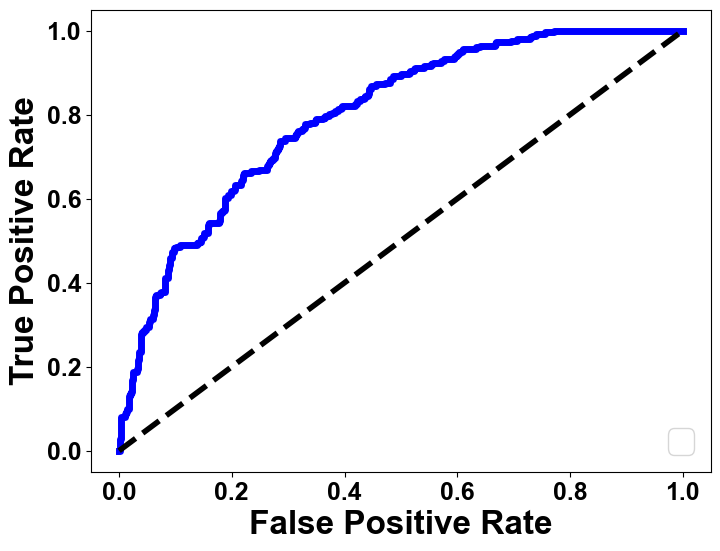

c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


圖表已儲存為 TIFF 檔案：C:/Users/USER/M1326168/MIMIC/DNR/20250528/ROC_curve.tiff


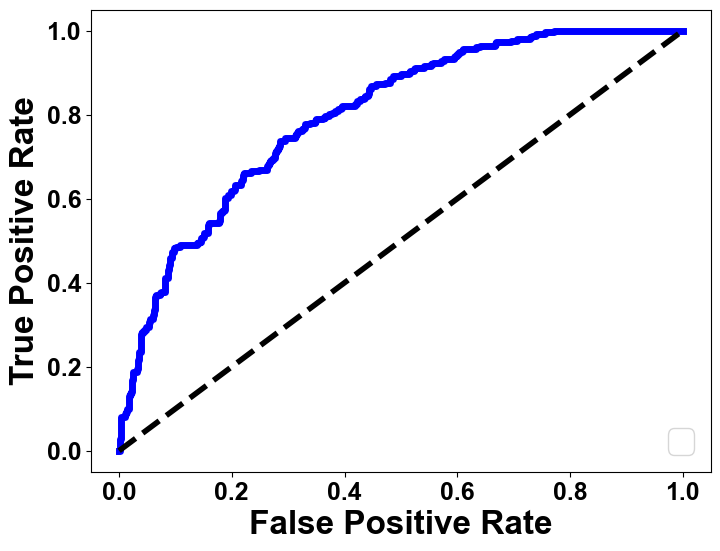

c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


圖表已儲存為 TIFF 檔案：C:/Users/USER/M1326168/MIMIC/DNR/20250528/ROC_curve.tiff


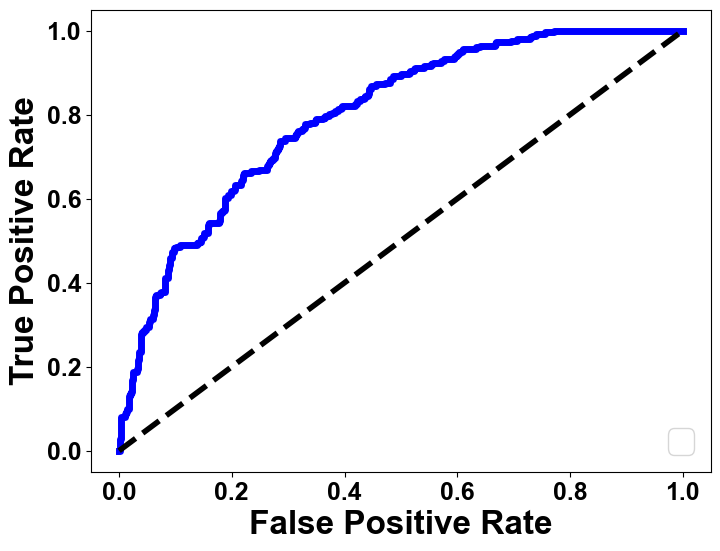

In [76]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(labels, preds, model_name, save_path=None):
    """
    繪製 ROC 曲線
    :param labels: 真實標籤
    :param preds: 預測機率
    :param model_name: 模型名稱
    :param save_path: 如果提供路徑，將圖表儲存為檔案
    """
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    # plt.plot(fpr, tpr, color='black', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    # plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Chance')
    #plt.plot(fpr, tpr, color='black', lw=2)
    plt.plot(fpr, tpr, color='blue', lw=5)

    plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=4)
    
    # 設定字體大小和樣式
    font_properties = {'size': 24, 'family': 'Arial', 'weight': 'bold'}
    plt.xlabel('False Positive Rate', fontdict=font_properties)
    plt.ylabel('True Positive Rate', fontdict=font_properties)
    #plt.title(f'ROC Curve - {model_name}', fontdict=font_properties)
    plt.legend(loc="lower right", prop={'size': 24, 'family': 'Arial', 'weight': 'bold'})
    
    # 設定刻度字體大小
    plt.xticks(fontsize=18, fontfamily='Arial', fontweight='bold')
    plt.yticks(fontsize=18, fontfamily='Arial', fontweight='bold')
    
    # # 儲存或顯示圖表
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #     print(f"ROC curve saved to {save_path}")
    # else:
    #     plt.show()

    output_path = f'C:/Users/USER/M1326168/MIMIC/DNR/20250528/ROC_curve.tiff'
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight')
    print(f"圖表已儲存為 TIFF 檔案：{output_path}")
    plt.show()

def run_roc_curve_on_tasks(local_best_model_dict, dataset_dict):
    """
    為每個任務繪製 ROC 曲線
    """
    for task_name in dataset_dict.keys():
        #model = local_best_model_dict[task_name]['model']
        model = local_best_model_dict['DNR']['model']
        model.eval()
        # X = dataset_dict[task_name].inputs.numpy()
        # Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
        X = dataset_dict['DNR'].inputs.numpy()
        Y = dataset_dict['DNR'].labels.unsqueeze(1).numpy()
        
        # 獲取預測機率
        # prob = model.predict_prob(X)[task_name].cpu().detach().numpy()
        prob = model.predict_prob(X)['DNR'].cpu().detach().numpy()
        
        # 繪製 ROC 曲線
        plot_roc_curve(Y.flatten(), prob.flatten(), model_name=task_name)

# 呼叫函數進行測試
print("Running ROC curve on Test Data...")
run_roc_curve_on_tasks(best_model_dict, test_dataset_dict)

In [45]:
# ROC curve
#彩色版 ，棄用

# import numpy as np
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# def plot_roc_curve(labels, preds, model_name, save_path=None):
#     """
#     繪製 ROC 曲線
#     :param labels: 真實標籤
#     :param preds: 預測機率
#     :param model_name: 模型名稱
#     :param save_path: 如果提供路徑，將圖表儲存為檔案
#     """
#     fpr, tpr, _ = roc_curve(labels, preds)
#     roc_auc = auc(fpr, tpr)
    
#     plt.figure(figsize=(8, 6))
#     # plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
#     # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
#     plt.plot(fpr, tpr, color='darkorange', lw=2)
#     plt.plot([0, 1], [0, 1], color='navy', lw=2)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'ROC Curve - {model_name}')
#     plt.legend(loc="lower right")
    
#     if save_path:
#         plt.savefig(save_path)
#         print(f"ROC curve saved to {save_path}")
#     else:
#         plt.show()

# def run_roc_curve_on_tasks(local_best_model_dict, dataset_dict):
#     """
#     為每個任務繪製 ROC 曲線
#     """
#     for task_name in dataset_dict.keys():
#         model = local_best_model_dict[task_name]['model']
#         model.eval()
#         X = dataset_dict[task_name].inputs.numpy()
#         Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
        
#         # 獲取預測機率
#         prob = model.predict_prob(X)[task_name].cpu().detach().numpy()
        
#         # 繪製 ROC 曲線
#         plot_roc_curve(Y.flatten(), prob.flatten(), model_name=task_name)

# print("Running ROC curve on Test Data...")
# run_roc_curve_on_tasks(best_model_dict, test_dataset_dict)

In [46]:
#delong test

import numpy as np
import scipy.stats as st

def load_predictions(filename):
    return np.load(filename)

def delong_test(preds1, preds2, labels):
    def _auc(X, Y):
        return 1 / (len(X) * len(Y)) * sum([_kernel(x, y) for x in X for y in Y])

    def _kernel(x, y):
        return 0.5 if x == y else int(y < x)

    def _structural_components(X, Y):
        V10 = [1 / len(Y) * sum([_kernel(x, y) for y in Y]) for x in X]
        V01 = [1 / len(X) * sum([_kernel(x, y) for x in X]) for y in Y]
        return V10, V01

    def _get_S_entry(V_A, V_B, auc_A, auc_B):
        return 1 / (len(V_A) - 1) * sum([(a - auc_A) * (b - auc_B) for a, b in zip(V_A, V_B)])
    
    X_A = [p for p, a in zip(preds1, labels) if a == 1]
    Y_A = [p for p, a in zip(preds1, labels) if a == 0]
    X_B = [p for p, a in zip(preds2, labels) if a == 1]
    Y_B = [p for p, a in zip(preds2, labels) if a == 0]
    
    auc_A = _auc(X_A, Y_A)
    auc_B = _auc(X_B, Y_B)

    V_A10, V_A01 = _structural_components(X_A, Y_A)
    V_B10, V_B01 = _structural_components(X_B, Y_B)

    var_A = (_get_S_entry(V_A10, V_A10, auc_A, auc_A) / len(V_A10) +
             _get_S_entry(V_A01, V_A01, auc_A, auc_A) / len(V_A01))
    var_B = (_get_S_entry(V_B10, V_B10, auc_B, auc_B) / len(V_B10) +
             _get_S_entry(V_B01, V_B01, auc_B, auc_B) / len(V_B01))
    covar_AB = (_get_S_entry(V_A10, V_B10, auc_A, auc_B) / len(V_A10) +
                _get_S_entry(V_A01, V_B01, auc_A, auc_B) / len(V_A01))
    
    z = (auc_A - auc_B) / ((var_A + var_B - 2 * covar_AB)**0.5 + 1e-8)
    p = st.norm.sf(abs(z)) * 2
    
    return auc_A, auc_B, z, p

def run_delong_test_on_tasks(local_best_model_dict, dataset_dict, task_name_list1, task_name_list2):
    preds1 = load_predictions('C:/Users/USER/M1326168/MIMIC/DNR/20250507/model_parm/DNR_predictions.npy')
    preds2 = []
    labels = None
    
    for task_name in task_name_list2:
        model = local_best_model_dict[task_name]['model']
        model.eval()
        X = dataset_dict[task_name].inputs.numpy()
        Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
        
        prob = model.predict_prob(X)[task_name].cpu().detach().numpy()
        preds2.extend(prob.flatten())
        if labels is None:
            labels = Y.flatten()
    
    auc_A, auc_B, z, p = delong_test(preds1, preds2, labels)
    
    delong_results = {'auc_model1': auc_A, 'auc_model2': auc_B, 'z_score': z, 'p_value': p}
    print(f"AUC Model of single-task learning: {auc_A:.5f}")
    #print(f"AUC Model of 3 task: {auc_A:.5f}")
    #print(f"AUC Model of multi-task learning: {auc_B:.5f}")
    print(f"AUC Model of 3 task learning: {auc_B:.5f}")
    #print(f"AUC Model of 5 task learning: {auc_B:.5f}")
    print(f"z-score: {z:.5f}")
    print(f"p-value: {p:.5f}")
    
    return delong_results

print("Running DeLong Test on Test Data...")
task_name_list1 = ['DNR']
#task_name_list1 = ['DNR','dod_30day','Vasopressor']
#task_name_list2 = ['DNR']
#task_name_list2 = ['DNR','dod_30day','Vasopressor','InvasiveVent','dialysis']
task_name_list2 = ['DNR','dod_30day','Vasopressor']
delong_results = run_delong_test_on_tasks(best_model_dict, test_dataset_dict, task_name_list1, task_name_list2)

Running DeLong Test on Test Data...


c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


AUC Model of single-task learning: 0.80135
AUC Model of 3 task learning: 0.79898
z-score: 0.60246
p-value: 0.54687


In [74]:
from sklearn.metrics import confusion_matrix


def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model


def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all
def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all , model_id,model_name_list):
    
    choose_colar = 'darkorange'
    if model_id == 1:
        choose_colar = 'blue'
    elif model_id == 2:
        choose_colar = 'green'
    else:
        choose_colar = 'red'
    
    choose_colar = 'black'
    #Plot

    #ax.plot(thresh_group, net_benefit_model, color = choose_colar)
    ax.plot(thresh_group, net_benefit_model, color = 'blue',lw = 5)

    #ax.plot(thresh_group, net_benefit_model, color = choose_colar, label = f'{model_name_list[model_id]}')
    
    if model_id == 1:
        #ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
        #ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')
        ax.plot(thresh_group, net_benefit_all, color = 'black',lw = 5)
        ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':',lw = 5)
    ax.plot(thresh_group, net_benefit_all, color = 'black',lw = 4)
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':',lw = 4)
    
    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'black', alpha = 0.2)
    
    font_properties = {'size': 24,  'family': 'Arial', 'fontweight':'bold'}
    plt.xticks(fontproperties='Arial', **font_properties)
    plt.yticks(fontproperties='Arial', **font_properties)
    
    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,1)
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'fontfamily':'Arial', 'fontsize': 24, 'fontweight':'bold'}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'fontfamily':'Arial', 'fontsize': 24, 'fontweight':'bold'}
        )
    
    #ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    #ax.legend(loc = 'upper right')
    plt.legend().set_visible(False)

    return ax

c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Model output keys: dict_keys(['DNR', 'dod_30day', 'Vasopressor'])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


圖表已儲存為 TIFF 檔案：C:/Users/USER/M1326168/MIMIC/DNR/20250528/decision_curve.tiff


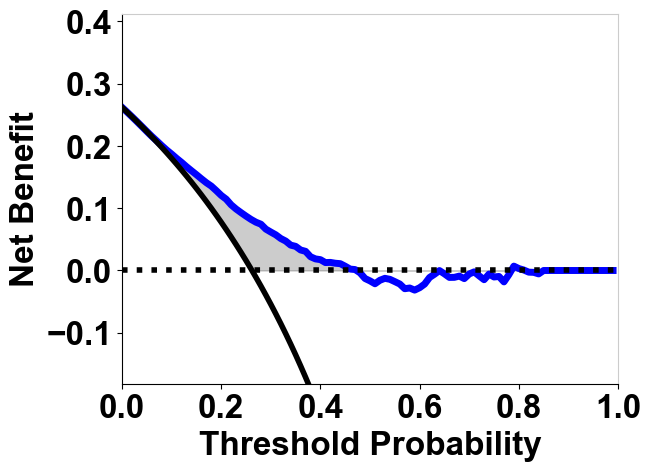

c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Model output keys: dict_keys(['DNR', 'dod_30day', 'Vasopressor'])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


圖表已儲存為 TIFF 檔案：C:/Users/USER/M1326168/MIMIC/DNR/20250528/decision_curve.tiff


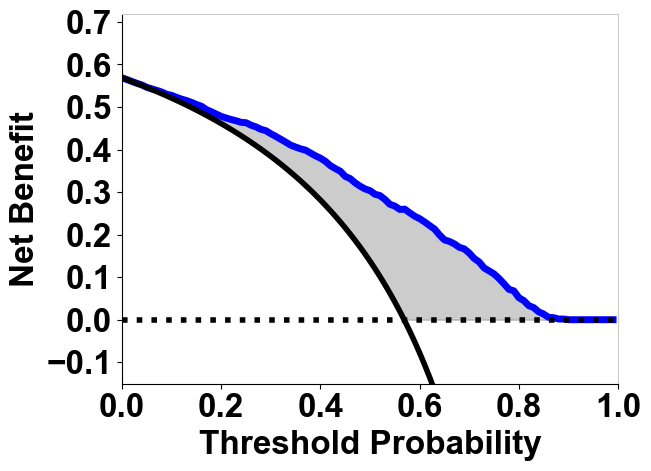

Model output keys: dict_keys(['DNR', 'dod_30day', 'Vasopressor'])


c:\Users\USER\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


圖表已儲存為 TIFF 檔案：C:/Users/USER/M1326168/MIMIC/DNR/20250528/decision_curve.tiff


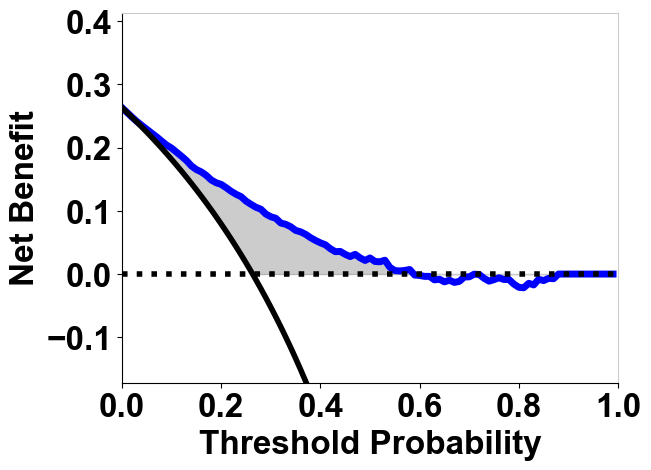

In [75]:
#decision_curve
def decision_curve(model_list, model_name_list, x, y, task_name):
    """
    繪製決策曲線
    """
    if torch.is_tensor(x):
        x = x.numpy()
        y = y.numpy()
        
    assert len(model_list) == len(model_name_list)
    fig, ax = plt.subplots()
    for i in range(len(model_list)):
        model = model_list[i]
        model.eval()
        if torch.is_tensor(x):
            x = x.cpu().numpy()
        x = torch.from_numpy(x).float().to(device)
        y_label = y

        # 模型預測
        out = model(x)
        if isinstance(out, dict):  # 如果輸出是字典
            print(f"Model output keys: {out.keys()}")  # 打印字典的鍵
            # 修改這裡，根據實際鍵名稱提取值
            y_pred_score = out.get('DNR', None)  # 使用 .get() 避免 KeyError
            if y_pred_score is None:
                raise KeyError("The key 'logits' was not found in the model output. Please check the output keys.")
        else:  # 如果輸出是張量
            y_pred_score = out

        y_pred_score = y_pred_score.float().cpu().detach().numpy()
        y_pred = (y_pred_score > 0.5).astype(int)
        
        # 計算 Net Benefit
        thresh_group = np.arange(0, 1, 0.01)
        net_benefit_model = calculate_net_benefit_model(thresh_group, y_pred_score, y_label)
        net_benefit_all = calculate_net_benefit_all(thresh_group, y_label)

        # 繪製決策曲線
        plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all, i, model_name_list)

    # plt.show()
    output_path = f'C:/Users/USER/M1326168/MIMIC/DNR/20250528/decision_curve.tiff'
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight')
    print(f"圖表已儲存為 TIFF 檔案：{output_path}")
    plt.show()

# 呼叫 decision_curve
for task_name in task_name_list2:
    model = best_model_dict[task_name]['model']
    model.eval()
    X = test_dataset_dict[task_name].inputs.numpy()
    Y = test_dataset_dict[task_name].labels.unsqueeze(1).numpy()
    
    
    # 呼叫 decision_curve，傳入正確的參數
    decision_curve(
        model_list=[model],  # 單一模型列表
        #model_name_list=[task_name],  # 單一模型名稱列表
        model_name_list=['DNR'],  # 單一模型名稱列表
        x=X,  # 測試資料的輸入
        y=Y,  # 測試資料的標籤
        task_name=task_name  # 任務名稱
    )

In [49]:
#棄用
# #decision_curve
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import precision_recall_curve

# def decision_curve_analysis(y_true, y_prob, thresholds=np.arange(0.0, 1.01, 0.01)):
#     net_benefit = []
#     for threshold in thresholds:
#         tp = np.sum((y_prob >= threshold) & (y_true == 1))
#         fp = np.sum((y_prob >= threshold) & (y_true == 0))
#         fn = np.sum((y_prob < threshold) & (y_true == 1))
#         tn = np.sum((y_prob < threshold) & (y_true == 0))       
#         n = len(y_true)
#         p = np.sum(y_true)
#         nb = (tp / n) - (fp / n) * (threshold / (1 - threshold))
#         net_benefit.append(nb)
    
#     return thresholds, net_benefit

# def plot_decision_curve(y_true, y_prob, model_name):
#     thresholds, net_benefit = decision_curve_analysis(y_true, y_prob)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(thresholds, net_benefit, label=f'{model_name} Decision Curve')
#     plt.plot(thresholds, thresholds * (np.sum(y_true) / len(y_true)), linestyle='--', label='Treat All')
#     plt.plot(thresholds, np.zeros_like(thresholds), linestyle='--', label='Treat None')
#     plt.xlabel('Threshold Probability')
#     plt.ylabel('Net Benefit')
#     plt.title('Decision Curve Analysis')
#     plt.legend()
#     plt.show()

# # 繪製決策曲線
# for task_name in task_name_list2:
#     model = best_model_dict[task_name]['model']
#     model.eval()
#     X = test_dataset_dict[task_name].inputs.numpy()
#     Y = test_dataset_dict[task_name].labels.unsqueeze(1).numpy()
    
#     prob = model.predict_prob(X)[task_name].cpu().detach().numpy()
#     plot_decision_curve(Y.flatten(), prob.flatten(), task_name)

In [50]:
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

def group_result(df):
    agg_columns = {
        'acc': ['mean', 'std'],
        'pre': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'auroc': ['mean', 'std'],
        'brier_score': ['mean', 'std']
    }
    df_group = df.groupby('task').agg(agg_columns)
    df_group.columns = [f"{col[0]}_{col[1]}" for col in df_group.columns]
    for metric in ['acc', 'pre', 'f1', 'recall', 'auroc','brier_score']:
        df_group[f"{metric}_combined"] = df_group.apply(
            lambda row: f"{row[f'{metric}_mean']:.4f} ± {row[f'{metric}_std']:.4f}", axis=1
        )
    df_result = df_group[[f"{metric}_combined" for metric in ['acc', 'pre', 'f1', 'recall', 'auroc','brier_score']]]
    df_result.reset_index(inplace=True)
    df_result.columns = ['task','acc', 'pre', 'f1', 'recall', 'auroc','brier_score']
    return df_result


def save_to_xlsx(df_save,file_name = 'output'):
    wb = Workbook()
    ws = wb.active
    for r_idx, row in enumerate(dataframe_to_rows(df_save, index=False, header=True), 1):
        for c_idx, value in enumerate(row, 1):
            ws.cell(row=r_idx, column=c_idx, value=value)
    #wb.save(f'./model_parm/{file_name}.xlsx')model.
    wb.save(f'C:/Users/USER/M1326168/MIMIC/DNR/20250507/model_parm/{file_name}.xlsx')

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
df_grade_group = group_result(df_grade)

In [51]:
df_grade_group


,task,acc,pre,f1,recall,auroc,brier_score
0,DNR,0.7283 ± 0.0183,0.4893 ± 0.0263,0.5606 ± 0.0105,0.6616 ± 0.0497,0.7985 ± 0.0051,0.1739 ± 0.0080
1,Vasopressor,0.8995 ± 0.0042,0.8331 ± 0.0247,0.8018 ± 0.0062,0.7745 ± 0.0229,0.9509 ± 0.0012,0.0775 ± 0.0018
2,dod_30day,0.8132 ± 0.0039,0.8421 ± 0.0158,0.8344 ± 0.0036,0.8271 ± 0.0190,0.8957 ± 0.0015,0.1345 ± 0.0015


In [52]:
save_to_xlsx(df_grade_group)

In [53]:
#df_columns = pd.read_csv("./data/sample/full_feature_name.csv")

#df_columns = pd.read_csv("C:/Users/USER/M1326168/MIMIC/DNR/20250219/data/sample/full_feature_name.csv")
df_columns = pd.read_csv("C:/Users/USER/M1326168/MIMIC/DNR/20250507/data/sample/full_feature_name.csv")
temperal = 0
feature_list = df_columns.columns.tolist()
for i in range(len(feature_list)):
    print(feature_list[i])
    if df_columns.columns[i] == 'gender':
        temperal = i

SaO2
Heart Rate
Systemic Systolic
Systemic Diastolic
Systemic Mean
Consecutive_avg_FiO2_Over50
Consecutive_Vasopressor_Over7
Consecutive_Vasopressor_Over3
Consecutive_avg_FiO2_Over60
Full_code_interval
Strength Arm
Strength Leg
dialysis_acc
dialysis_since_last_event
dialysis_over3
dialysis_over7
ICU_Class_1
ICU_Class_2
ICU_Class_3
use_vent_over3
FiO2
Minute Ventilation
Mean Airway Pressure
Peak Airway Pressure
PEEP
Plateau
Tidal Volume
Respiratory Rate
RASS
Platelets x1000
WBC x1000
Hgb
PO2
PaCO2
Glucose
BUN
pH
Sodium
Potassium
Magnesium
Calcium
Chloride
creatinine
HCO3
Phosphate
PT-INR
Sedation
PPI
Pain control
total
Fluid_intake_value
Nutrition_Enteral_value
Urine_value
Aspergillus
Candida
Abdomen
Blood
Respiratory tract
Skin and soft tissue
Urinary tract
Others
Anxiety
Assess for anxiety, depression, or delirium which may contribut
Asystole
Blood Transfusion
Consult to pastoral care, social services, palliative care, psy
Early mobilization
Encourage family to participate in care
Enc

In [54]:
print(f'時序特徵:{temperal}  靜態特徵:{len(df_columns.columns)-temperal}')

時序特徵:126  靜態特徵:145
